#### 树回归-CART

In [3]:
!ls datasets/

abalone.txt	  email		    horseColicTest.txt	    svm_RBF2.txt
dating_test1.txt  ex0.txt	    horseColicTraining.txt  svm_RBF.txt
dating_test.txt   ex1.txt	    housing.csv		    svm.txt
digits		  horse-colic.data  play


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
def load_data(file_name):
    data = []
    #y = []
    with open(file_name) as file:
        for line in file.readlines():
            curr_line = line.strip().split("\t")
            curr_line = [float(e) for e in curr_line]
            #x0, y0 = curr_line[:-1], curr_line[-1]
            #X.append(x0)
            data.append(curr_line)
    return data

In [10]:
# 按照指定列切分数据
def split_dataset(X, feature_idx, value):
    ldata, rdata = [], []
    for data in X:
        if data[feature_idx] < value:
            ldata.append(data)
        else:
            rdata.append(data)
    return ldata, rdata

In [4]:
a=np.mat(np.eye(4))
a

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [21]:
a[np.nonzero(a[:,0]>0.5)[0]][0]

matrix([[1., 0., 0., 0.]])

In [22]:
a[np.nonzero(a[:,0]<=0.5)[0]]

matrix([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [12]:
type(a)

numpy.matrix

In [13]:
def choose_best_feature(dataset, fleaf, ferr, opt):
    ''' 选取最佳分割特征和特征值
    dataset: 待划分的数据集
    fleaf: 创建叶子节点的函数
    ferr: 计算数据误差的函数
    opt: 回归树参数.
        err_tolerance: 最小误差下降值;
        n_tolerance: 数据切分最小样本数
    '''
    dataset = np.array(dataset)
    m, n = dataset.shape
    err_tolerance, n_tolerance = opt['err_tolerance'], opt['n_tolerance']
    err = ferr(dataset)
    best_feat_idx, best_feat_val, best_err = 0, 0, float('inf')
    # 遍历所有特征
    for feat_idx in range(n - 1):
        values = dataset[:, feat_idx]
        # 遍历所有特征值
        for val in values:
            # 按照当前特征和特征值分割数据
            ldata, rdata = split_dataset(dataset.tolist(), feat_idx, val)
            if len(ldata) < n_tolerance or len(rdata) < n_tolerance:
                # 如果切分的样本量太小
                continue
            # 计算误差
            new_err = ferr(ldata) + ferr(rdata)
            if new_err < best_err:
                best_feat_idx = feat_idx
                best_feat_val = val
                best_err = new_err
    # 如果误差变化并不大归为一类
    if abs(err - best_err) < err_tolerance:
        return None, fleaf(dataset)
    # 检查分割样本量是不是太小
    ldata, rdata = split_dataset(dataset.tolist(), best_feat_idx,
                                 best_feat_val)
    if len(ldata) < n_tolerance or len(rdata) < n_tolerance:
        return None, fleaf(dataset)
    return best_feat_idx, best_feat_val

In [50]:
file_name="datasets/ex0.txt"
dataset=load_data(file_name)
dataset[:10]

[[1.0, 0.067732, 3.176513],
 [1.0, 0.42781, 3.816464],
 [1.0, 0.995731, 4.550095],
 [1.0, 0.738336, 4.256571],
 [1.0, 0.981083, 4.560815],
 [1.0, 0.526171, 3.929515],
 [1.0, 0.378887, 3.52617],
 [1.0, 0.033859, 3.156393],
 [1.0, 0.132791, 3.110301],
 [1.0, 0.138306, 3.149813]]

In [31]:
type(dataset)

list

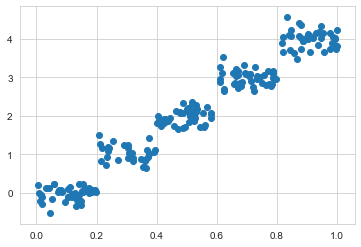

In [15]:
dataset = np.array(dataset)
# 绘制散点
plt.scatter(dataset[:, 1], dataset[:, 2])

In [16]:
def fleaf(dataset):
    ''' 计算给定数据的叶节点数值, 这里为均值
    '''
    dataset = np.array(dataset)
    return np.mean(dataset[:, -1])

def ferr(dataset):
    ''' 计算数据集的误差.
    '''
    dataset = np.array(dataset)
    m, _ = dataset.shape
    return np.var(dataset[:, -1])*dataset.shape[0]

In [17]:
def create_tree(dataset, fleaf, ferr, opt=None):
    ''' 递归创建树结构
    dataset: 待划分的数据集
    fleaf: 创建叶子节点的函数
    ferr: 计算数据误差的函数
    opt: 回归树参数.
        err_tolerance: 最小误差下降值;
        n_tolerance: 数据切分最小样本数
    '''
    if opt is None:
        opt = {'err_tolerance': 1, 'n_tolerance': 4}
    # 选择最优化分特征和特征值
    feat_idx, value = choose_best_feature(dataset, fleaf, ferr, opt)

    # 触底条件
    if feat_idx is None:
        return value
    # 创建回归树
    tree = {'feat_idx': feat_idx, 'feat_val': value}
    # 递归创建左子树和右子树
    ldata, rdata = split_dataset(dataset, feat_idx, value)
    ltree = create_tree(ldata, fleaf, ferr, opt)
    rtree = create_tree(rdata, fleaf, ferr, opt)
    tree['left'] = ltree
    tree['right'] = rtree
    return tree

In [27]:
from functools import namedtuple
import uuid
def get_nodes_edges(tree, root_node=None):
    ''' 返回树中所有节点和边
    '''
    Node = namedtuple('Node', ['id', 'label'])
    Edge = namedtuple('Edge', ['start', 'end'])

    nodes, edges = [], []

    if type(tree) is not dict:
        return nodes, edges

    if root_node is None:
        label = '{}: {}'.format(tree['feat_idx'], tree['feat_val'])
        root_node = Node._make([uuid.uuid4(), label])
        nodes.append(root_node)

    for sub_tree in (tree['left'], tree['right']):
        if type(sub_tree) is dict:
            node_label = '{}: {}'.format(sub_tree['feat_idx'], sub_tree['feat_val'])
        else:
            node_label = '{:.2f}'.format(sub_tree)
        sub_node = Node._make([uuid.uuid4(), node_label])
        nodes.append(sub_node)

        edge = Edge._make([root_node, sub_node])
        edges.append(edge)

        sub_nodes, sub_edges = get_nodes_edges(sub_tree, root_node=sub_node)
        nodes.extend(sub_nodes)
        edges.extend(sub_edges)

    return nodes, edges

In [20]:
def dotify(tree):
    ''' 获取树的Graphviz Dot文件的内容
    '''
    content = 'digraph decision_tree {\n'
    nodes, edges = get_nodes_edges(tree)

    for node in nodes:
        content += '    "{}" [label="{}"];\n'.format(node.id, node.label)

    for edge in edges:
        start, end = edge.start, edge.end
        content += '    "{}" -> "{}";\n'.format(start.id, end.id)
    content += '}'

    return content

In [55]:
def tree_predict(data, tree):
    ''' 根据给定的回归树预测数据值
    '''
    if type(tree) is not dict:
        return tree

    feat_idx, feat_val = tree['feat_idx'], tree['feat_val']
    # print( feat_idx, feat_val)
    if data[feat_idx] < feat_val:
        sub_tree = tree['left']
    else:
        sub_tree = tree['right']

    return tree_predict(data, sub_tree)

In [29]:
dotfile = 'datasets/{}.dot'.format("ext0")
with open(dotfile, 'w') as f:
    content = dotify(tree)
    f.write(content)

In [32]:
type(dataset)

list

In [36]:
dataset[:10]

array([[ 1.      ,  0.409175,  1.88318 ],
       [ 1.      ,  0.182603,  0.063908],
       [ 1.      ,  0.663687,  3.042257],
       [ 1.      ,  0.517395,  2.305004],
       [ 1.      ,  0.013643, -0.067698],
       [ 1.      ,  0.469643,  1.662809],
       [ 1.      ,  0.725426,  3.275749],
       [ 1.      ,  0.39435 ,  1.118077],
       [ 1.      ,  0.50776 ,  2.095059],
       [ 1.      ,  0.237395,  1.181912]])

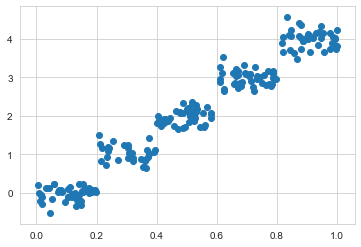

In [34]:
dataset = np.array(dataset)
plt.scatter(dataset[:, 1], dataset[:, 2])

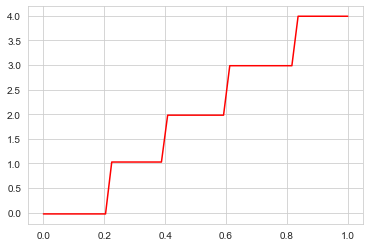

In [56]:
 # 绘制回归曲线
x = np.linspace(0, 1, 50)
y = [tree_predict([i], tree) for i in x]
plt.plot(x, y, c='r')

In [53]:
dataset=load_data("datasets/myex0.txt")
tree = create_tree(dataset,
                   fleaf,
                   ferr,
                   opt={
                       'n_tolerance': 4,
                       'err_tolerance': 1
                   })
tree

{'feat_idx': 0,
 'feat_val': 0.400158,
 'left': {'feat_idx': 0,
  'feat_val': 0.208197,
  'left': -0.023838155555555553,
  'right': 1.0289583666666666},
 'right': {'feat_idx': 0,
  'feat_val': 0.609483,
  'left': 1.980035071428571,
  'right': {'feat_idx': 0,
   'feat_val': 0.816742,
   'left': 2.9836209534883724,
   'right': 3.9871632}}}

In [39]:
x = np.linspace(0, 1, 50)
x

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [57]:
tree_predict(x, tree)
# as https://zhuanlan.zhihu.com/p/30744760

-0.023838155555555553

In [ ]:
# 增加理解书上脚本，完善